In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools

%matplotlib inline

In [5]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    return np.exp(-scipy.spatial.distance.cdist(X1,X2,'sqeuclidean')/(2*sigma**2))

def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (offset + linear_kernel(X1,X2))**degree


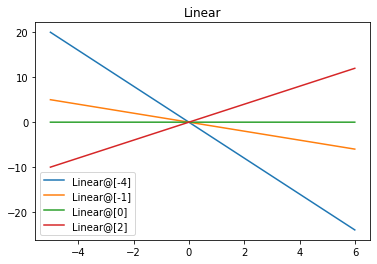

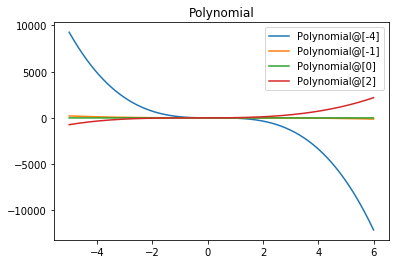

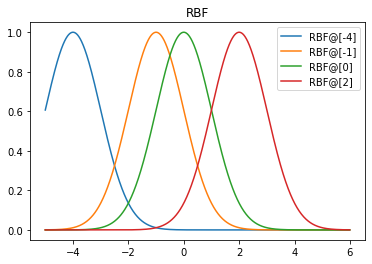

In [6]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.title("Linear")
plt.show()

# Polynomial kernel
y = polynomial_kernel(prototypes,xpts,1,3)
for i in range(len(prototypes)):
    label = "Polynomial@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.title("Polynomial")
plt.show()


# RBF
y = RBF_kernel(prototypes,xpts,1)
for i in range(len(prototypes)):
    label = "RBF@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.title("RBF")
plt.show()


 
 

In [7]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        return self.kernel(X,self.prototype_points) @ self.weights
        

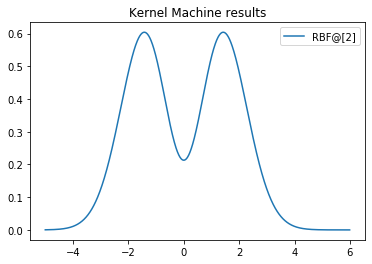

In [8]:
KM = Kernel_Machine(lambda x1,x2:RBF_kernel(x1,x2,1),np.array([-1,0,1]).reshape(-1,1),np.array([1,-1,1]))
y= KM.predict(xpts)
plt.plot(xpts, y, label=label)
plt.legend(loc = 'best')
plt.title("Kernel Machine results")
plt.show()

## 2.1 Kernel Ridge Regression

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [10]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

In [11]:
# plot the training data
plt.scatter(x_train, y_train)
plt.title("Training data")
plt.show()

In [12]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    # solve for kernel values K = kernel(X,X)
    K = kernel(X,X)
    
    # Solve for alpha such that K @ alpha - y is minimized
    alpha = np.linalg.inv(l2reg * np.eye(len(K)) + K) @ y
    
    return Kernel_Machine(kernel, X, alpha)

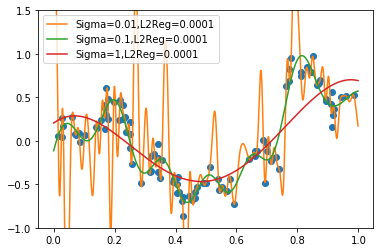

In [13]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

It looks like a very small sigma of 0.01 causes drastic overfitting caused by large alpha values. The larger values of sigma may be less likely to overfit, with the sigma value of 1 possibly even underfitting.

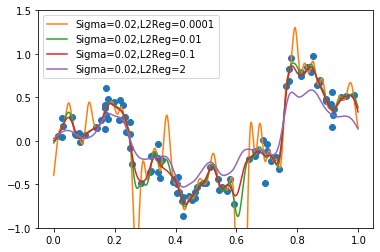

In [14]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

As the regularization parameter gets larger, the prediction line gets pulled toward the mean y value of all the points in the training set--it would become a straight flat line around 0.4

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [16]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [51]:
param_grid = [{'kernel': ['RBF'],'sigma':np.arange(.01,.1,.005), 'l2reg': np.exp2(-np.arange(-5,5,.5))},
              {'kernel':['polynomial'],'offset':np.arange(-6,6,.5), 'degree':[5,10,15,20,25],'l2reg':np.exp2(-np.arange(-5,5,1)) },
              {'kernel':['linear'],'l2reg': np.exp2(-np.arange(-5,5,.5))}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False),
                    return_train_score = True
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise-deprecating',
             estimator=KernelRidgeRegression(degree=2, kernel='RBF', l2reg=1,
                                             offset=1, sigma=1),
             iid='warn', n_jobs=None,
             param_grid=[{'kernel': ['RBF'],
                          'l2reg': array([32.        , 22.627417  , 16.        , 11.3137085 ,  8.        ,
        5.65685425,  4.        ,  2.82842712,  2.        ,  1.41421356,
        1.        ,  0.70710678,  0.5       ,  0.35355339,  0.25...
       -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,
        5. ,  5.5])},
                         {'kernel': ['linear'],
                          'l2reg': array([32.        , 22.627417  , 16.        , 11.3137085 ,  8.        ,
        5.65685425,  4.        ,  2.82842712,  2.        ,  1.41421356,
        1.        ,  0.70710678,  0.5       ,  0.35355339,  0.25      ,
        0.1767

In [52]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

param_degree param_kernel  param_l2reg param_offset param_sigma  \
280             -          RBF     0.176777            -        0.06   
261             -          RBF     0.250000            -       0.055   
317             -          RBF     0.088388            -       0.065   
299             -          RBF     0.125000            -       0.065   
336             -          RBF     0.062500            -        0.07   
242             -          RBF     0.353553            -        0.05   
354             -          RBF     0.044194            -        0.07   
298             -          RBF     0.125000            -        0.06   
243             -          RBF     0.353553            -       0.055   
262             -          RBF     0.250000            -        0.06   
...           ...          ...          ...          ...         ...   
1392           25   polynomial     4.000000           -6           -   
1199           20   polynomial     2.000000          5.5           -   
1272           20   polynomial     0.125000           -6           -   
368             5   polynomial    32.000000           -2           -   
1256           20   polynomial     0.250000           -2           -   
1493           25   polynomial     0.250000         -3.5           -   
1320           25   polynomial    32.000000           -6           -   
1530           25   polynomial     0.125000            3           -   
1508           25   polynomial     0.250000            4           -   
1556           25   polynomial     0.062500            4           -   

      mean_test_score  mean_train_score  
280          0.013805          0.014446  
261          0.013828          0.014199  
317          0.013832          0.014256  
299          0.013839          0.014737  
336          0.013847          0.014575  
242          0.013878          0.014016  
354          0.013884          0.014194  
298          0.013894          0.013956  
243          0.013897          0.014932  
262          0.013922          0.015103  
...               ...               ...  
1392      1259.315999         95.663512  
1199      1412.690860        373.513870  
1272      1432.729790       1326.858392  
368       1491.735671       1351.373374  
1256      1673.833877        739.985034  
1493      2310.360146       1510.499986  
1320      3526.191334       1755.509959  
1530     48232.211294      42049.742146  
1508     69025.120722       2448.432889  
1556    911033.147251      76555.618780  

[1580 rows x 7 columns]

In [53]:
# Can be a more convenient way to look at the table
import qgrid 
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folderd_toshow = df[show].fillna('-')
qgrid.show_grid(df_toshow)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

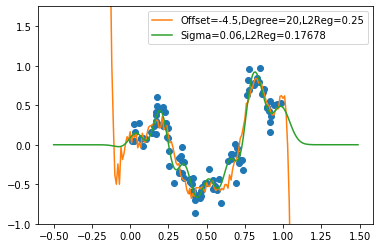

In [55]:
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= -4.5
degree = 20
l2reg = .25
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = .06
l2reg= .17678
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

The 20 degree polynomial did the best job only considering the mean squared error term, and I would NEVER put a model like that into production. The RBF function on the other hand seems to have elegantly fit the overall trends and gracefully handled extrapolation (even if it just returns a neutral guess of zero). I'm impressed. I think I'll use it in my data project for sure!